## Phase 2 - Advanced analytics + EDA

### Smart Exploration Problem - Marketing campaign optimization

##### This Notebook complement phase 1 - initial EDA with aditional information detailed below

- 1. EDA (Exploratory Data Analysis) in more detail
- 2. Build 3 machine learning models and compare the results achieved
- 3. Choose the best model and save it for backup and future use
- 4. Make predictions to give guidences for Ad's priority
- 5. Present the first option for prediction using R and H2O
- 6. Summary and quick review

###### This Jupyter Notebook is going to be developed using R and H2O (cluster running in CentOS)

In [2]:
## Load libraries used in this Notebook
library(data.table)
library(tidyverse)
library(h2o)

### Connect Notebook to H2O cluster

In [3]:
## connect to h2o cluster
h2o.connect('centos')

 Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         36 minutes 4 seconds 
    H2O cluster timezone:       America/Sao_Paulo 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.26.0.3 
    H2O cluster version age:    3 months and 24 days !!! 
    H2O cluster name:           userds1 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   5.75 GB 
    H2O cluster total cores:    1 
    H2O cluster allowed cores:  1 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          centos 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4 
    R Version:                  R version 3.6.1 (2019-07-05) 


Warning message in h2o.clusterInfo():
"
Your H2O cluster version is too old (3 months and 24 days)!
Please download and install the latest version from http://h2o.ai/download/"

## Remove all objects from H2O cluster
- Clean memory

In [4]:
h2o.removeAll()

### Load the dataset - historical data

In [5]:
df <- fread('./data/Historical_Data_Smart_Exploration_Demo_Simulation__CPE.csv')

## Remove columns that is not going to be used and define the target feature
remove_columns <- c('LineItemsID', 'URL', 'spend', 'engagement', 'clicks')
target <- 'CPE'

features <- setdiff(colnames(df), remove_columns)
df <- df[, ..features]

df$xyz_campaign_id <- as.factor(df$xyz_campaign_id)
df$channel <- as.factor(df$channel)
df$channel_ad_id <- as.factor(df$channel_ad_id)
df <- df %>% mutate_if(., is.character, as.factor)

## Filter Spend - CPE > 0
df <- df[df$CPE > 0, ]

## Head the data.frame
head(df)

,xyz_campaign_id,channel,channel_ad_id,gender,age,interest,CPE
1,916,1,2,M,45-65+,Interest - 15,0.01
2,916,11,2,M,45-65+,Interest - 16,0.01
4,916,11,1,M,45-65+,Interest - 28,0.01
5,916,1,1,M,45-65+,Interest - 28,0.01
7,916,11,1,M,45-65+,Interest - 15,0.04
8,916,1,1,M,45-65+,Interest - 16,0.01


## EDA - Exploratory Data Analysis

#### CPE by campaign

- Campaign 1178 was launched many time and have the worse CPE  average of \$0.72
- Campaign 936 have around 45% ocurrencies compared to campaign 1178 and its CPE average is just \$ 0.08 (10% of campaign 1178)
- Campaign 916 do not have many line items launched and have even lower CPE average of $0.03

xyz_campaign_id,n,total_CPE,avg_CPE
916,34,1.17,0.03441176
936,280,23.03,0.08225000
1178,613,445.36,0.72652529


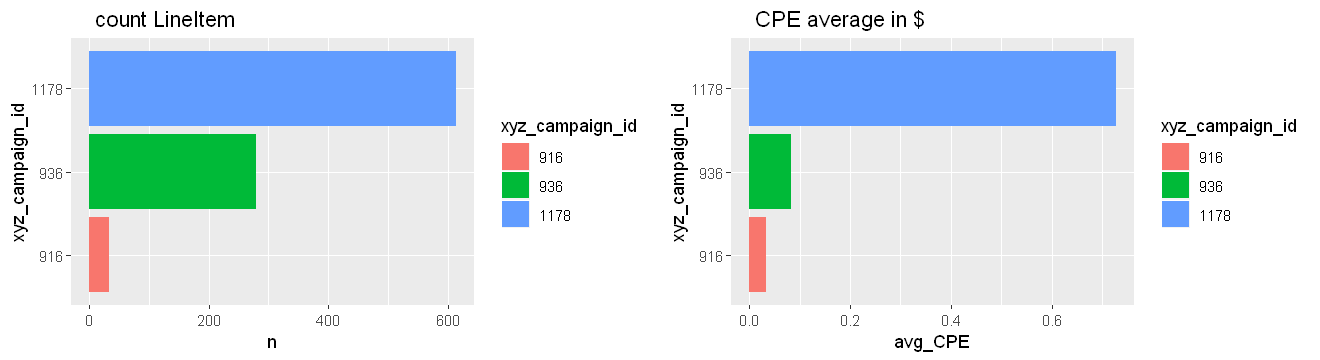

In [6]:
## CPE BY CAMPAIGN
options(repr.plot.width = 11, repr.plot.height = 3)

## EDA - CPE by Campaign
df_group <- df %>% group_by(xyz_campaign_id) %>% summarise(n = n(), total_CPE = sum(CPE), avg_CPE = mean(CPE))

## Average
gg1 <- qplot(data=df_group, x=xyz_campaign_id, y=avg_CPE, geom='col', fill=xyz_campaign_id, main='    CPE average in $') + 
coord_flip()

## Count
gg2 <- qplot(data=df_group, x=xyz_campaign_id, y=n, geom='col', fill=xyz_campaign_id, main='    count LineItem') + 
coord_flip()

gridExtra::grid.arrange(gg2, gg1, nrow = 1)

df_group %>% head()


## Evaluation of top 3 features with higher impact on CPE

#### CPE by Interest and campaign

- TOP 10 lower CPE average
- Campaign 918 have much less ocurrence in the data and not all interest are presented
- Interests seems similar between campaigns when presented with lower values to interest 31 and 36

interest,n,CPE_mean
Interest - 36,15,0.1093333
Interest - 31,17,0.1405882
Interest - 66,10,0.1840000
Interest - 2,18,0.2233333
Interest - 24,22,0.2436364
Interest - 102,7,0.2457143
Interest - 21,25,0.2644000
Interest - 23,18,0.2650000
Interest - 30,18,0.2738889
Interest - 22,30,0.2773333


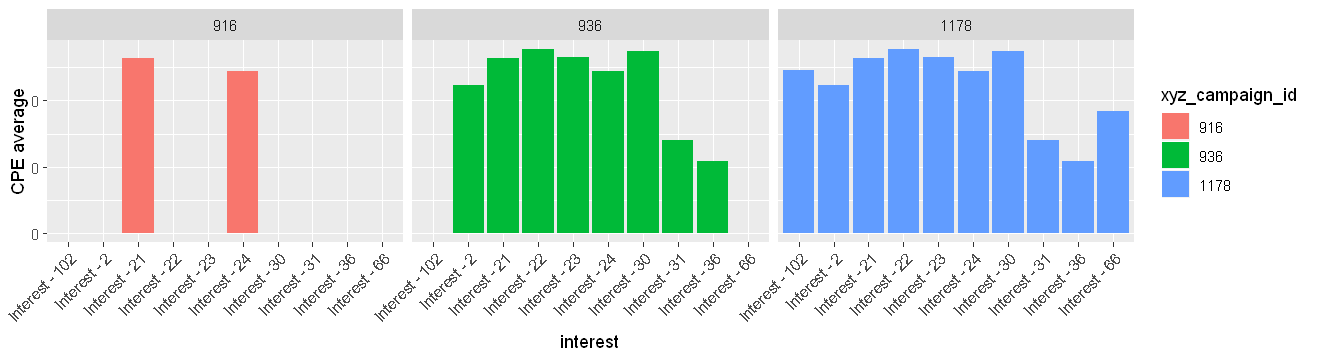

In [7]:
df_top10_interest <- df %>% group_by(interest) %>% summarise(n = n(), CPE_mean = mean(CPE)) %>% arrange(CPE_mean ) %>% head(10)
df_top10_interest_plot <- merge(df_top10_interest, df, by = 'interest') 
df_top10_interest_plot %>% group_by(interest, xyz_campaign_id) %>% summarise(CPE_mean = mean(CPE_mean)) %>% 
  qplot(data=., x=interest, y= CPE_mean, fill=xyz_campaign_id, facets = ' xyz_campaign_id ~ .', geom='col') +
  scale_y_continuous(name="CPE average", labels = scales::comma)  + 
  theme(axis.text.x = element_text(angle = 45, hjust = 1))


df_top10_interest

#### CPE by Age

- All age distribution have CPE average higher than \$0.40 
- Age between 25-34 have the highest CPE average of \$0.72 
- Age between 18-24 and 45-65+ have the lowes CPE average and will probably get better margin (in terms of CPE) in current campaign 

age,n,total_CPE,avg_CPE
45-65+,302,121.98,0.4039073
18-24,209,88.86,0.4251675
35-44,187,92.69,0.4956684
25-34,229,166.03,0.7250218


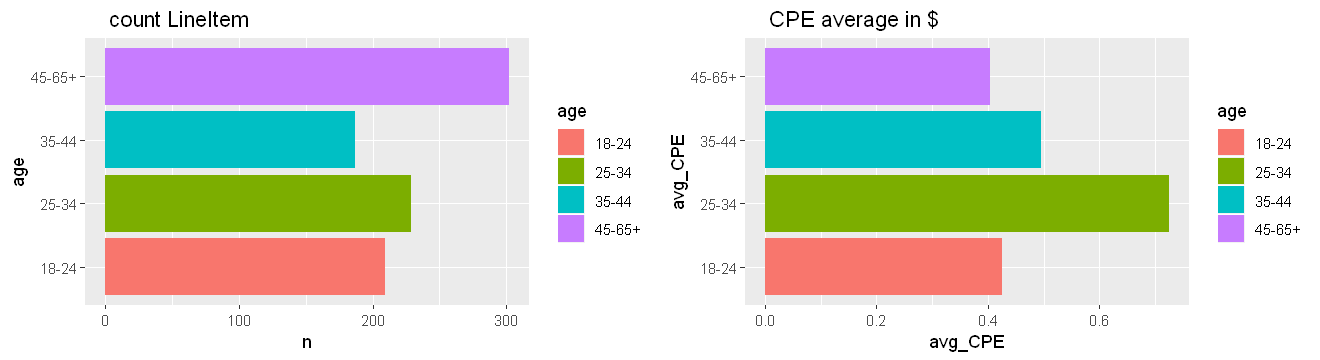

In [8]:
## CPE BY Age
options(repr.plot.width = 11, repr.plot.height = 3)

## EDA - CPE by Campaign
df_group <- df %>% group_by(age) %>% summarise(n = n(), total_CPE = sum(CPE), avg_CPE = mean(CPE)) %>% arrange(avg_CPE)

## Average
gg1 <- qplot(data=df_group, x=age, y=avg_CPE, geom='col', fill=age
             , main='    CPE average in $', xlab='avg_CPE') + coord_flip()

## Count
gg2 <- qplot(data=df_group, x=age, y=n, geom='col', fill=age, main='    count LineItem') + 
coord_flip()

gridExtra::grid.arrange(gg2, gg1, nrow = 1)

df_group %>% head()

#### CPE by Age and gender
- age 25-34 (higher distribution) and age 45-65+ (lower distribution) influence the CPE more than others and all have outliers
- Age from 25-34 and gender Female have higher CPE distribution than others and seems to impact even more higher CPE tan Man
- Age 45-65+ contribute for lower CPE for both (man and women)

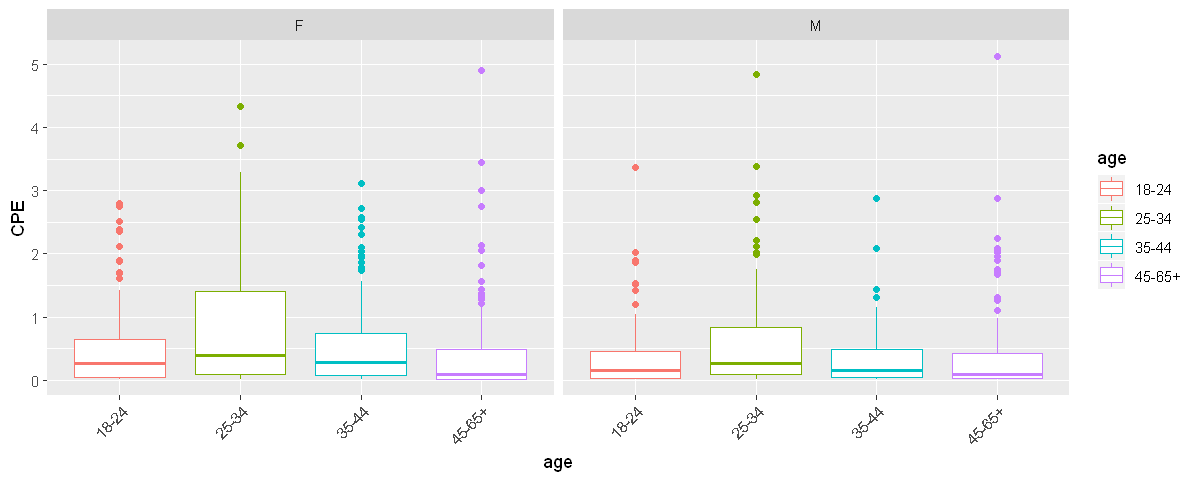

In [9]:
options(repr.plot.width = 10, repr.plot.height = 4)
qplot(data=df, x=age, y=CPE, geom='boxplot', color=age, facets = ' gender ~ .') +
  scale_y_continuous(name="CPE", labels = scales::comma)  + 
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

#### CPE by channel_ad_id

- Channel ad id 2 have the lowest CPE average followed by channel_ad_id 2
- Channel ad id 0 have fewer ocurrencies however also have lower CPE average of \$0.37
- All other channel  ad id have an CPE average higher than \$0.40

channel_ad_id,n,total_CPE,avg_CPE
1,462,64.93,0.1405411
2,153,51.99,0.3398039
0,5,1.87,0.3740000
3,78,49.45,0.6339744
4,61,47.85,0.7844262
5,41,35.10,0.8560976
21,1,0.89,0.8900000
6,22,24.93,1.1331818
8,13,16.98,1.3061538
7,16,20.97,1.3106250


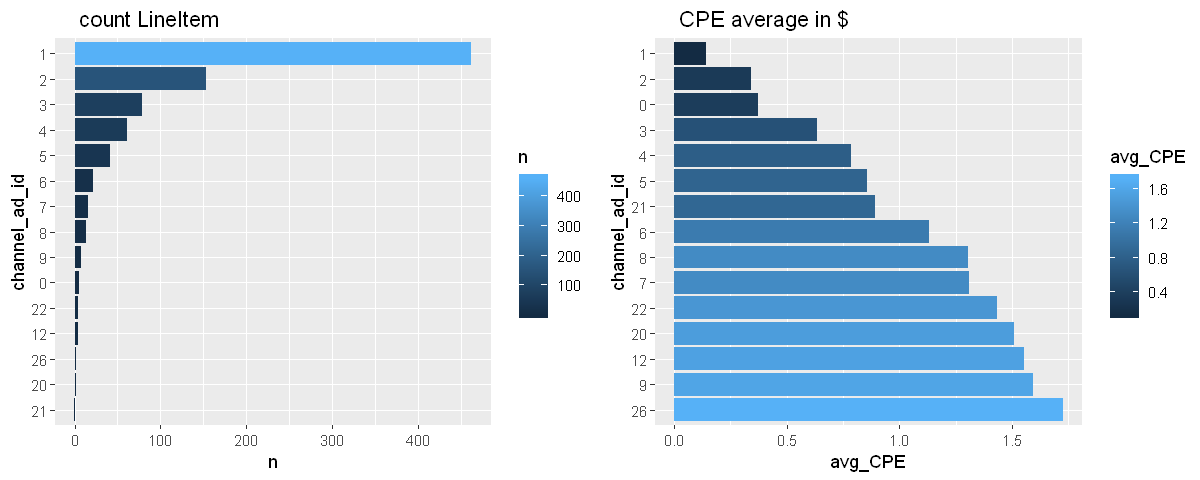

In [10]:
df_group <- df %>% group_by(channel_ad_id) %>% summarise(n = n(), total_CPE = sum(CPE), avg_CPE = mean(CPE)) %>% 
    arrange(avg_CPE) %>% head(20)

## Average
gg1 <- qplot(data=df_group[1:15, ], x=reorder(channel_ad_id,-avg_CPE), y=avg_CPE, geom='col', fill=avg_CPE, 
             main='    CPE average in $', xlab='channel_ad_id') + coord_flip()

## Count
gg2 <- qplot(data=df_group[1:15, ], x=reorder(channel_ad_id,n), y=n, geom='col', fill=n, 
             main='    count LineItem' , xlab='channel_ad_id') + 
  coord_flip()

gridExtra::grid.arrange(gg2, gg1, nrow = 1)

df_group %>% head(10)


#### Evalution of CPE distribution
- CPE has skewed distribution and in this type of scenario probably is better to work with CPE in logarithm scale

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


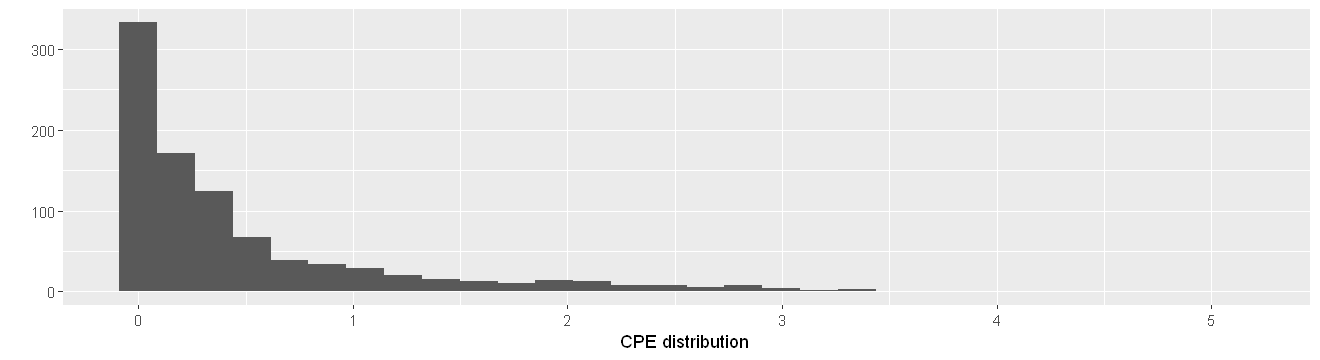

In [11]:
## CPE  distribution 
## CPE BY CAMPAIGN
options(repr.plot.width = 11, repr.plot.height = 3)
qplot(df$CPE, xlab = 'CPE distribution ')

#### Quick recap until now

- The top 3 influencers of CPE metric are channel ad id, interest and age
- Campaign 936 and 916 have much lower CPE average
- Gender Female with age between 25-34 tends to have higher CPE than others 
- Channel ad id (1,2 and 0) have lower CPE average and will probably provide higher margin profit in current campaign
- Ages distribution 45-65+ and 18-25 have lower CPE than others to all genders (male and female)
- Interest 31 and 36 will  also provide higher margin profit to the current campaign

## Starting point to use AI and Machine Learning to predict CPE (Cost per Engagement) 
- After the prediction it is possible to identify and assing priority to respective Line Item
- The metrics R2 (coeficient of determination) and evaluation metrics RMSE / MAE will be used to choose the best machine learning model
- All executions will use cross validation strategy with 5 folds


#### Preparation of the data to build ml models with h2o

In [12]:
## h2o features and target
h2o_features <- setdiff(features, 'CPE')
df$logCPE <- log1p(df$CPE)
target_CPE <- 'CPE'
target_log_CPE <- 'logCPE'
hdf <- as.h2o(df, destination_frame = 'hdf_CPE.hex')
print('H2O features')
h2o_features

  |======================================================================| 100%
[1] "H2O features"


[1] "xyz_campaign_id" "channel"         "channel_ad_id"   "gender"         
[5] "age"             "interest"

#### RF build and performance with default CPE

In [13]:
## execution of Random Forest
fit_rf_CPE <- h2o.randomForest(x = h2o_features,
                   y = target_CPE,
                   training_frame = hdf,
                   model_id = 'RF_CPE.model',
                   nfolds = 5,
                   seed = 12345)
h2o.performance(fit_rf_CPE)

  |======================================================================| 100%


H2ORegressionMetrics: drf
** Reported on training data. **
** Metrics reported on Out-Of-Bag training samples **

MSE:  0.2025541
RMSE:  0.4500601
MAE:  0.2534986
RMSLE:  0.2036857
Mean Residual Deviance :  0.2025541
R^2 :  0.629772


#### RF build model and performande with CPE in logarithmic scale
- CPE in logarithmic scale have better results (higher R2 and lower RMSE/MAE) compared with default value
- Use of log_CPE for prediction
<br>
<br>
  Obs.: to work with default CPE again if necessary, use exponencial function (over logarithmic scale) to get CPE default value again. Example: expm1(log_CPE)

In [14]:
## execution of Random Forest
fit_rf_log_CPE <- h2o.randomForest(x = h2o_features,
                   y = target_log_CPE,
                   training_frame = hdf,
                   model_id = 'RF_log_CPE.model',
                   nfolds = 5,
                   seed = 12345)
h2o.performance(fit_rf_log_CPE)

  |======================================================================| 100%


H2ORegressionMetrics: drf
** Reported on training data. **
** Metrics reported on Out-Of-Bag training samples **

MSE:  0.04142841
RMSE:  0.2035397
MAE:  0.1374481
RMSLE:  0.1311561
Mean Residual Deviance :  0.04142841
R^2 :  0.6999998


### Build and evaluate second machine learning model

### GLM - Generalized Linear Model

- One interesting point of GLM using H2O is the automatic creation of One Hot Encoding for categorical features when build the model
- All metrics (R2, RMSE and MAE) are worse with GLM compared to Random Forest as show below

##### GLM build model and performande with default CPE

In [15]:
## execution of GLM - cross validation with 5 folds and CPE
fit_glm_CPE <- h2o.glm(x = h2o_features,
                   y = target_CPE,
                   training_frame = hdf,
                   model_id = 'GLM_CPE.model',
                   nfolds = 5,
                   seed = 12345)
h2o.performance(fit_glm_CPE)

  |======================================================================| 100%


H2ORegressionMetrics: glm
** Reported on training data. **

MSE:  0.2998948
RMSE:  0.5476265
MAE:  0.3338792
RMSLE:  0.2521584
Mean Residual Deviance :  0.2998948
R^2 :  0.4518528
Null Deviance :507.1676
Null D.o.F. :926
Residual Deviance :278.0025
Residual D.o.F. :915
AIC :1540.304


#### GLM build model and performande with CPE in logarithmic scale

In [16]:
## execution of GLM - cross validation with 5 folds and log of CPE (skewed distribution)
fit_glm_log_CPE <- h2o.glm(x = h2o_features,
                   y = target_log_CPE,
                   training_frame = hdf,
                   model_id = 'GLM_log_CPE.model',
                   nfolds = 5,
                   seed = 12345)
h2o.performance(fit_glm_log_CPE)

  |======================================================================| 100%


H2ORegressionMetrics: glm
** Reported on training data. **

MSE:  0.06176227
RMSE:  0.2485202
MAE:  0.1748241
RMSLE:  0.1576422
Mean Residual Deviance :  0.06176227
R^2 :  0.552754
Null Deviance :128.0137
Null D.o.F. :926
Residual Deviance :57.25363
Residual D.o.F. :916
AIC :73.51525


## Feature importance - GLM

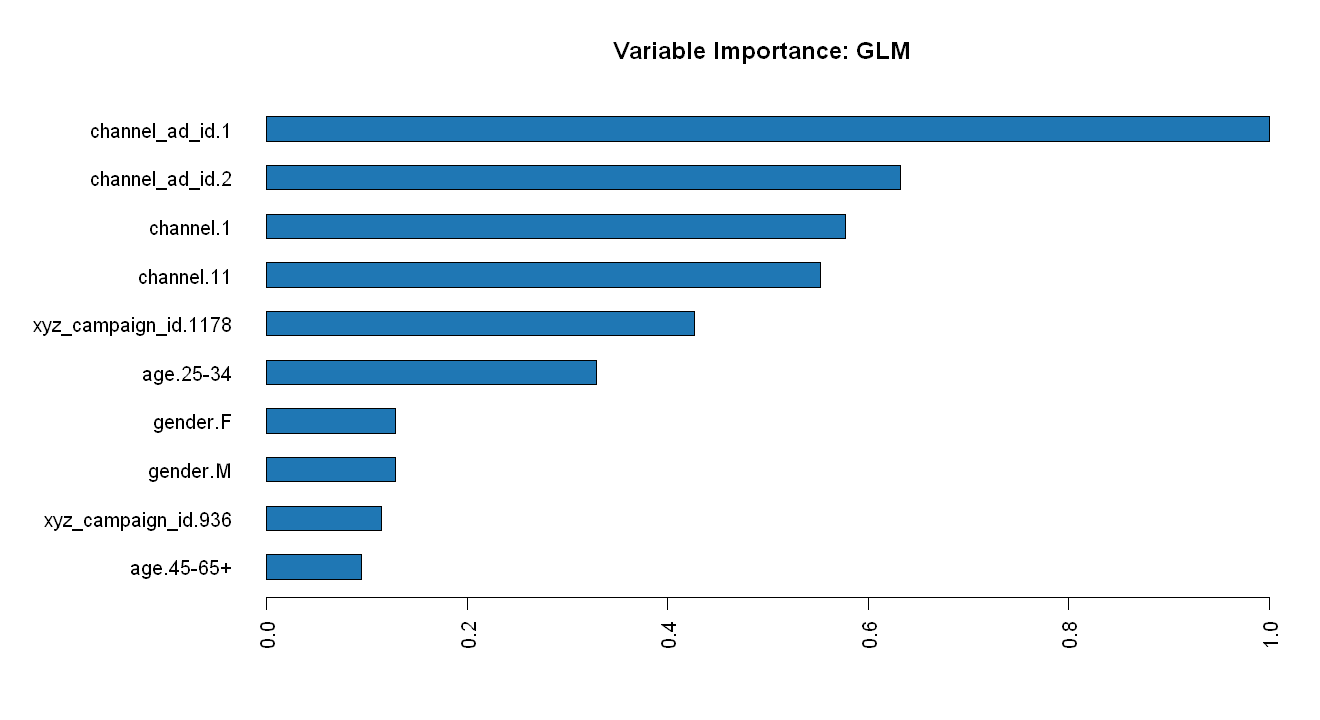

In [17]:
options(repr.plot.width = 11, repr.plot.height = 6)
h2o.varimp_plot(fit_glm_CPE)

#### GLM results
- The GLM algorithm shows the coeficient of determination (R2) worse than Random Forest
- The RMSE and MAE are lower when working with CPE in logarithm scale (skewed distribution) as expected 
- Channel_ad_id.1 e channel_ad_id.2 have higher influence in the CPE (confirmation of explanation above)
- Campaign 1178 has big negative impact on CPE
- All others features/characterist of data were already explained the influence over CPE (positive and negative) and again presented above in the chart
<br> age.25-34
<br> gender.F
<br> gender.M
<br> campaign 936
<br> age.45-65+
- Interesting point to evaluate are channel 1 and channel 11 with higher influence also in CPE and presented below

#### Top 10 channel with lowest CPE average

- channel 12 has only one ocurrency and so without influence in CPE average
- channel 1 and 11 have lower CPE average than others and below of \$0.40
- all other channel have the CPE average higher than \$0.99

channel,n,total_CPE,avg_CPE
12,1,0.28,0.2800000
11,417,117.99,0.2829496
1,334,117.27,0.3511078
2,81,80.18,0.9898765
3,35,39.53,1.1294286
4,24,34.71,1.4462500
5,7,11.06,1.5800000
14,2,3.34,1.6700000
6,7,12.02,1.7171429
9,3,5.16,1.7200000


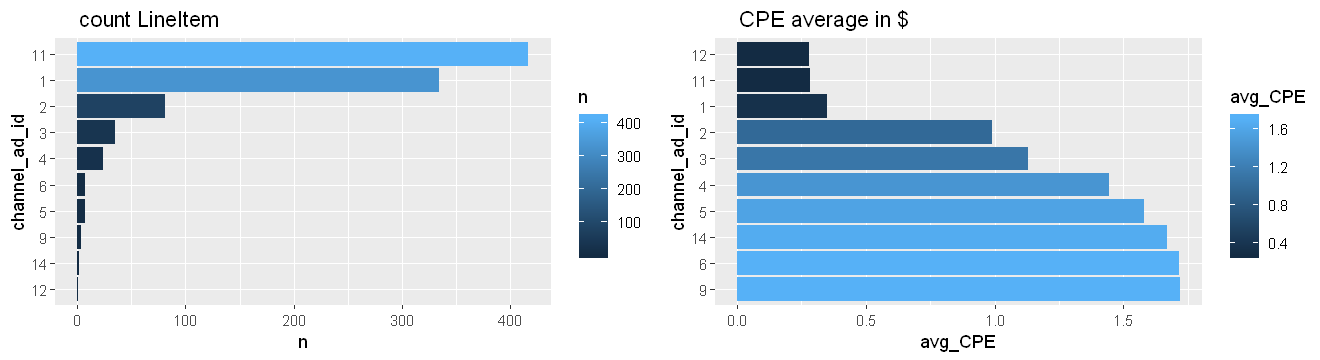

In [18]:
## CPE BY CHANNEL
options(repr.plot.width = 11, repr.plot.height = 3)

df_group <- df %>% group_by(channel) %>% summarise(n = n(), total_CPE = sum(CPE), avg_CPE = mean(CPE)) %>% 
  arrange(avg_CPE) %>% head(10)

## Average
gg1 <- qplot(data=df_group[1:10, ], x=reorder(channel,-avg_CPE), y=avg_CPE, geom='col', fill=avg_CPE, 
             main='    CPE average in $', xlab='channel_ad_id') + coord_flip()

## Count
gg2 <- qplot(data=df_group[1:10, ], x=reorder(channel,n), y=n, geom='col', fill=n, 
             main='    count LineItem' , xlab='channel_ad_id') + 
  coord_flip()

gridExtra::grid.arrange(gg2, gg1, nrow = 1)

df_group %>% head(10)


### GBM ( Gradient Boosting Machine ) - build and  performance

- GBM has the best results compared to Random Forest and GLM
- GBM achieved
<br> R^2 :  0.92
<br> RMSE:  0.10
<br> MAE:  0.07

#### GBM build model and performande with CPE in logarithmic scale


In [19]:
## execution of GBM
fit_gbm_log_CPE <- h2o.gbm(x = h2o_features,
                   y = target_log_CPE,
                   training_frame = hdf,
                   model_id = 'GBM_log_CPE.model',
                   nfolds = 5,
                   seed = 12345)
h2o.performance(fit_gbm_log_CPE)

  |======================================================================| 100%


H2ORegressionMetrics: gbm
** Reported on training data. **

MSE:  0.01096274
RMSE:  0.1047031
MAE:  0.07048631
RMSLE:  0.07453724
Mean Residual Deviance :  0.01096274
R^2 :  0.9206143


### Plot feature importance - GBM

###### The 3 most important features that impact CPE in this historical data are exactly the same of Random Forest:
- channel_ad_id
- interest and
- age



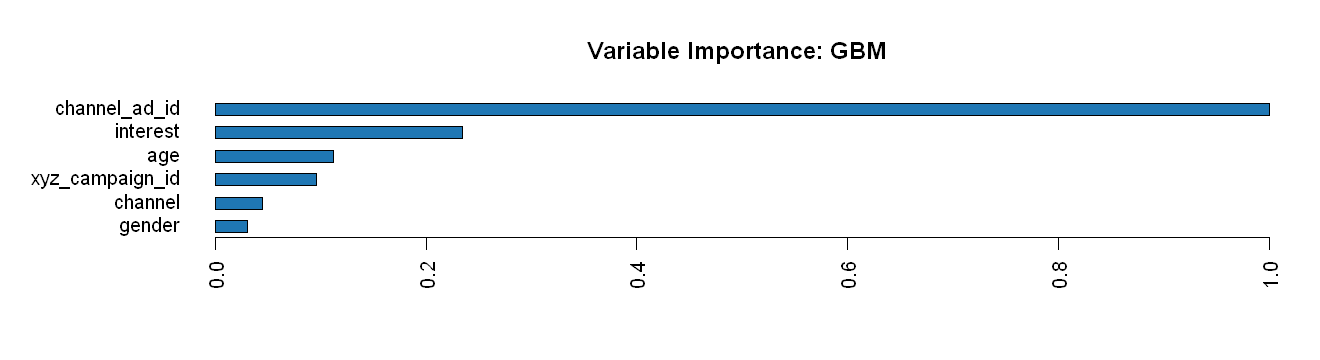

In [20]:
h2o.varimp_plot(fit_gbm_log_CPE)

#### Considerations about machine learning model performance and possible improvements

- These 3 machine learning models (Random Forest, GLM and GBM) could provide even better accuracy with hyper parameter tuning and Feature Engineering for example

## Example to export model using command line

<div class="alert alert-block alert-info">
<b>Info:</b> Save/export the GBM (best perfomance) model for deployment
</div>

In [21]:
## Export model with command Line
gbmmodel_Path <- h2o.saveModel(fit_gbm_log_CPE, 'GBM_MODEL')
gbmmodel_Path


[1] "/home/userds1/H2O_JAR/GBM_MODEL/GBM_log_CPE.model"

### Prediction and deployment

#### The model that achieve the best result was GBM - Gradient Boosting Machine

The code below present one option do run the model with current campaing data and assing priority to each line item ID

#### Rules applied for prediction and assign priority to Line Item ID
- 1. Save the model for future use and backup
- 2. Load the model again for prediction 
- 3. Load newdata and apply same and apply the same rules during the model building (training done with cross-validation)
- 4. Run the prediction with current campaign data to get CPE prediction
- 5. Convert CPE from logaritmic scale default CPE value
- 6. Assing prioritty to each line item. This rule was implemented in 3 steps as shown below
<br> 6.1: filter all Line Item ID with engagement higher than specific threshold (>= xxxx)
<br> 6.2: sort the new data based on lowest CPE to highest CPE
<br> 6.3: apply the rank from lowest CPE to highers CPE


In [22]:

### CODE SAMPLE TO SAVE THE MODEL, PREDICT with NEW DATA AND ASSIGN PRIORITY TO Line Item ID

## this demo data used engagement = xxx and for a real scenario choose engagement higher than specific threshold (>= xxxx)

# # Code to predict and assing priority -------------------------------------
# 
# getwd()
# 
# ## Save the model for backup and future use
# gbmmodel_Path <- h2o.saveModel(fit_gbm_log_CPE, 'GBM_MODEL')
# 
# ## To load the model again to make prediction just use
# fit_gbm_log_CPE <- h2o.loadModel(gbmmodel_Path)
# 
# ## All metrics results still available for later evaluation for example
# h2o.performance(fit_gbm_log_CPE)
# 
# ## Load newdata
# newdata <- fread('../data/CURRENT_CAMPAIGN_Smart_Exploration.csv')
# head(newdata)
# 
# ## Apply same rules used to buil the model
# newdata$xyz_campaign_id <- as.factor(newdata$xyz_campaign_id)
# newdata$channel <- as.factor(newdata$channel)
# newdata$channel_ad_id <- as.factor(newdata$channel_ad_id)
# newdata <- newdata %>% mutate_if(., is.character, as.factor)
# summary(newdata)
# 
# ## Make Predictions using H2O
# h2o_newdata <- as.h2o(newdata, destination_frame = 'current_campaign')
# predict_log_CPE <- h2o.predict(fit_gbm_log_CPE, newdata=h2o_newdata )
# 
# ## Convert the Prediction to CPE default value and assing to each line item
# log_CPE <- as.data.frame(predict_log_CPE)
# newdata$CPE <- exp(df_predict_log_CPE$predict - 1)
# summary(newdata$CPE)
# 
# 
# ## Example of rule that could be used to assing priority
# ##### 1. Filter current data with engagements higher than xxxx
# ##### 2. Rank Line Item ID with lower CPE or lower than CPE average for example
# 
# ## code to filter engagement higher than specific threshold
# newdata %>% filter(engagement >= 'xxx')
# 
# ## code to assing rank priority based on lower CPE
# newdata <- newdata %>% arrange(CPE)
# newdata$Rank <- rownames(newdata)
# head(newdata)
# 
# # final code --------------------------------------------------------------


## Summary and considerations

##### The top 3 influencers of CPE metric are channel ad id, interest and age
- Campaign 936 and 916 have much lower CPE average
- Gender Female with age between 25-34 tends to have higher CPE than others
- Channel ad id (1,2 and 0) have lower CPE average and will probably provide higher margin profit in current campaign
- Ages distribution 45-65+ and 18-25 have lower CPE than others to all genders (male and female)
- Interest 31 and 36 will also provide higher margin profit in current campaign

##### The machine learning model GBM achieved the best results compared to Random Forest and GLM
GBM performance metrics
- R^2 : 0.92
- RMSE: 0.10
- MAE: 0.07

##### Deployment considerations
- The GBM model build and already saved could be deployed to be used as a batch process (current campaign data) with predictions presented above and also as a java application or microservices architecture for online prediction for specific use cases for example

###### The next and last notebook (Phase 3 - Deployment) will provide more information related to the deployment and predictions